# mp4 -> wav

In [ ]:
from audio_extract import extract_audio
import os

video_folder = "data/seul_game/"
audio_folder = "data/seul_game/audio/"

for filename in os.listdir(video_folder):
    if filename.lower().endswith(".mp4"):
        input_path = os.path.join(video_folder, filename)
        output_path = os.path.join(audio_folder, os.path.splitext(filename)[0] + ".wav")
        extract_audio(
            input_path=input_path,
            output_path=output_path,
            output_format="wav"
        )

# clean transcripts

In [ ]:
import re
from datetime import timedelta
import os
import json
from tqdm import tqdm
import torch

def time_to_seconds(time_str):
    parts = list(map(int, time_str.split(":")))
    return (
        timedelta(minutes=parts[0], seconds=parts[1]).total_seconds()
        if len(parts) == 2
        else timedelta(
            hours=parts[0], minutes=parts[1], seconds=parts[2]
        ).total_seconds()
    )

stop_phrases = ['Редактор субтитров А.Семкин Корректор А.Егорова',
                'Субтитры добавил DimaTorzok',
                'Аллах Акбар, Иблис Аллах',
                'Редактор субтитров А.Синецкая Корректор А.Егорова',
                'Субтитры делал DimaTorzok',
                'ПОКА!',
                'Продолжение следует...',
                'Спасибо за просмотр!',
                'Удачи!']

def remove_stop_phrases(text, stop_list):
    for phrase in stop_list:
        text = re.sub(re.escape(phrase), '', text, flags=re.IGNORECASE)
    return re.sub(r'\s{2,}', ' ', text).strip()

model, utils = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=True
)

(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

def detect_vad_end(start_sec, wav, total, max_duration=60):
    sr = 16000
    start_sample = int(sr * start_sec)
    end_sample = min(total, start_sample + sr * max_duration)
    segment = wav[start_sample:end_sample]

    speech_timestamps = get_speech_timestamps(
        segment.unsqueeze(0),
        model,
        sampling_rate=sr,
        return_seconds=True
    )
    if speech_timestamps:
        last_end = speech_timestamps[-1]['end']
        return min(start_sec + last_end, total / sr)
    return min(start_sec + 30, total / sr)

def reformat(filepath, audio_path, output_json):
    with open(filepath, "r", encoding="utf-8") as file:
        lines = file.readlines()[3:]  

    print(f"Working on {filepath}...")

    transcription_data = []
    pattern = re.compile(
        r"(\d+:\d+:\d+|\d+:\d+)\s*-\s*(.*?)\n(.*?)(?=\n\d+:\d+:\d+|\n\d+:\d+|$)", re.DOTALL
    )

    text = "".join(lines)

    matches = list(pattern.finditer(text))
    print(f"Всего совпадений: {len(matches)}")

    sr=16000
    wav = read_audio(audio_path, sampling_rate=sr)
    total = wav.shape[0]

    for match in tqdm(matches, total=len(matches), desc="Обработка сегментов"):
        start_time = match.group(1)
        speaker = match.group(2).strip()
        raw_text = match.group(3).strip().replace("\n", " ")

        clean_text = remove_stop_phrases(raw_text, stop_phrases)

        if not clean_text:
            continue 

        start_seconds = time_to_seconds(start_time)
        transcription_data.append(
            {
                "start": start_seconds,
                "end": None,
                "speaker": speaker,
                "text": clean_text,
            }
        )

    for i in tqdm(range(len(transcription_data) - 1)):
        proposed_start = max(1, int(transcription_data[i + 1]["start"] - transcription_data[i]["start"]))
        end_seconds = detect_vad_end(transcription_data[i]["start"], wav, total, max_duration=min(60, proposed_start))
        transcription_data[i]["end"] = end_seconds
    last_start = transcription_data[-1]["start"]
    end_seconds = detect_vad_end(last_start, wav, total, max_duration=min(60, (total / sr) - last_start))
    transcription_data[-1]["end"] = end_seconds

    merged = []
    i = 0
    while i < len(transcription_data):
        curr = transcription_data[i]
        j = i + 1
        while j < len(transcription_data):
            next_ = transcription_data[j]
            same_speaker = ((curr["speaker"] == next_["speaker"]) or (next_["speaker"] == "Неопознанный оратор") or (curr["speaker"] == "Неопознанный оратор")) and (next_['start'] - curr['start'] < 120)
            words = len((curr["text"] + " " + next_["text"]).split())

            if same_speaker and words <= 60:
                curr["end"] = next_["end"]
                curr["text"] = (curr["text"] + " " + next_["text"]).strip()
                j += 1
            else:
                break
        merged.append(curr)
        i = j

    with open(output_json, "w", encoding="utf-8") as json_file:
        json.dump(merged, json_file, ensure_ascii=False, indent=4)

    print(f"Saved {len(merged)} segments to {output_json}")

    return

In [2]:
transcription_folder = "/home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/"
audio_folder = "/home/llm_agent/video_audio_pipeline/data/seul_game/audio/"
for filename in os.listdir(transcription_folder):
    if filename.lower().endswith(".txt"):
        audio_path = filename.split('_mp4')[0].replace('_', '.') + '.wav'
        reformat(filepath=transcription_folder+filename, audio_path=audio_folder+audio_path, output_json=transcription_folder+filename[:filename.find("_mp4")]+'_formatted.json')

Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_5_mp4 Транскрипт.txt...
Всего совпадений: 251


100%|██████████| 250/250 [00:57<00:00,  4.37it/s]


Saved 211 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_5_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_3_mp4 Транскрипт.txt...
Всего совпадений: 604


100%|██████████| 603/603 [01:14<00:00,  8.09it/s]


Saved 472 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_3_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_4_mp4 Транскрипт.txt...
Всего совпадений: 164


100%|██████████| 162/162 [00:17<00:00,  9.15it/s]


Saved 108 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_4_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/A1_6(2)_mp4 Транскрипт.txt...
Всего совпадений: 237


100%|██████████| 236/236 [00:44<00:00,  5.30it/s]


Saved 181 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/A1_6(2)_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/A1_6(1)_mp4 Транскрипт.txt...
Всего совпадений: 232


100%|██████████| 231/231 [00:30<00:00,  7.47it/s]


Saved 121 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/A1_6(1)_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_4(2)_mp4 Транскрипт.txt...
Всего совпадений: 211


100%|██████████| 210/210 [00:37<00:00,  5.65it/s]


Saved 143 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А2_4(2)_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А1_7_mp4 Транскрипт.txt...
Всего совпадений: 541


100%|██████████| 540/540 [01:28<00:00,  6.09it/s]


Saved 393 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/А1_7_formatted.json
Working on /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/A1_5_mp4 Транскрипт.txt...
Всего совпадений: 462


100%|██████████| 461/461 [01:22<00:00,  5.61it/s]


Saved 325 segments to /home/llm_agent/video_audio_pipeline/data/seul_game/transcriptions/A1_5_formatted.json


# push to huggingface

In [4]:
import json, glob
from datasets import load_dataset, Dataset
from huggingface_hub import create_repo, HfApi
import soundfile as sf
import os
import re
from tqdm import tqdm

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002500-\U00002BEF"  # chinese characters
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"
        "\u3030"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

records = []
audio_dir = "../data/seul_game/audio"
for js_path in glob.glob("../data/seul_game/processed_transcriptions/*.json"):
    filename = js_path.split('/')[-1]
    base_name = filename.split('_formatted')[0].replace('_', '.')
    audio_path = audio_dir + '/' + base_name + '.wav'
    waveform, sr = sf.read(audio_path)
    with open(js_path, encoding="utf-8") as f:
        segments = json.load(f)
    for i, seg in tqdm(enumerate(segments), total = len(segments)):
        if i < 10 or len(segments) - i < 6:
            continue
        start_frame = int(seg["start"] * sr)
        end_frame = int(seg["end"] * sr)
        cleaned_text = remove_emojis(seg["corrected_text"])
        if seg["end"] - seg["start"] > 30 and seg["end"] - seg["start"] < 0.5:
            continue 
        chunk_waveform = waveform[start_frame:end_frame]

        segment_filename = f"{base_name}_segment_{i}.wav"
        segment_path = os.path.join(audio_dir, 'segments', segment_filename)
        sf.write(segment_path, chunk_waveform, sr)

        records.append({
            "audio": segment_path,
            "text": cleaned_text,
            "speaker": seg.get("speaker", "")
        })

ds = Dataset.from_list(records)

100%|██████████| 393/393 [00:11<00:00, 34.51it/s]


In [5]:
from datasets import Audio
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))

In [6]:
ds

Dataset({
    features: ['audio', 'text', 'speaker'],
    num_rows: 1834
})

In [7]:
from datasets import DatasetDict

ds = ds.shuffle(seed=42)
train_testvalid = ds.train_test_split(test_size=0.2, seed=42)

test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

train_dataset = train_testvalid['train'] 
validation_dataset = test_valid['train']
test_dataset = test_valid['test']       

split_datasets = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset,
})

In [8]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'speaker'],
        num_rows: 1467
    })
    validation: Dataset({
        features: ['audio', 'text', 'speaker'],
        num_rows: 183
    })
    test: Dataset({
        features: ['audio', 'text', 'speaker'],
        num_rows: 184
    })
})

In [9]:
repo_id = "nixiieee/seul-game-processed-30s"
api = HfApi()
api.create_repo(repo_id, private=True, repo_type="dataset")

split_datasets.push_to_hub(repo_id, private=True, max_shard_size="2GB")

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/734 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Map:   0%|          | 0/733 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/nixiieee/seul-game-processed-30s/commit/693a81a53555a46ab5e432d961c6ed19a9ca59bc', commit_message='Upload dataset', commit_description='', oid='693a81a53555a46ab5e432d961c6ed19a9ca59bc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/nixiieee/seul-game-processed-30s', endpoint='https://huggingface.co', repo_type='dataset', repo_id='nixiieee/seul-game-processed-30s'), pr_revision=None, pr_num=None)

In [7]:
check_ds = load_dataset(repo_id)
check_ds

README.md:   0%|          | 0.00/626 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/296M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/193 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/193 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'speaker'],
        num_rows: 1544
    })
    validation: Dataset({
        features: ['audio', 'text', 'speaker'],
        num_rows: 193
    })
    test: Dataset({
        features: ['audio', 'text', 'speaker'],
        num_rows: 193
    })
})

# perplexity analysis

In [38]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model     = GPT2LMHeadModel.from_pretrained("gpt2").eval()

def perplexity(text: str) -> float:
    tokens = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens, labels=tokens["input_ids"])
    loss = outputs.loss.item()
    return torch.exp(torch.tensor(loss)).item()

In [ ]:
# example 
window = ""
print("Perplexity:", perplexity(window))

Perplexity: 7.644632339477539


Working on А2_4(2)_formatted.json...


100%|██████████| 143/143 [00:21<00:00,  6.71it/s]


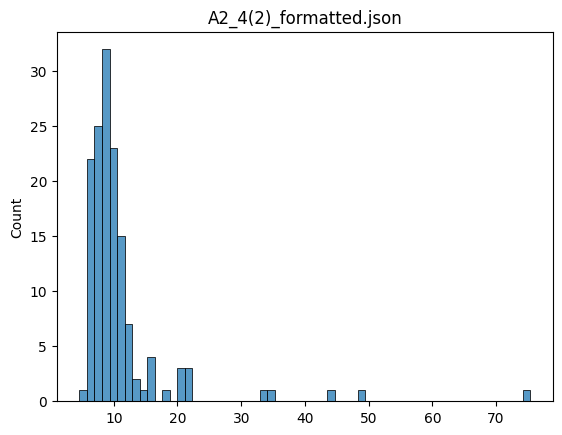

Working on A1_6(2)_formatted.json...


100%|██████████| 181/181 [00:29<00:00,  6.07it/s]


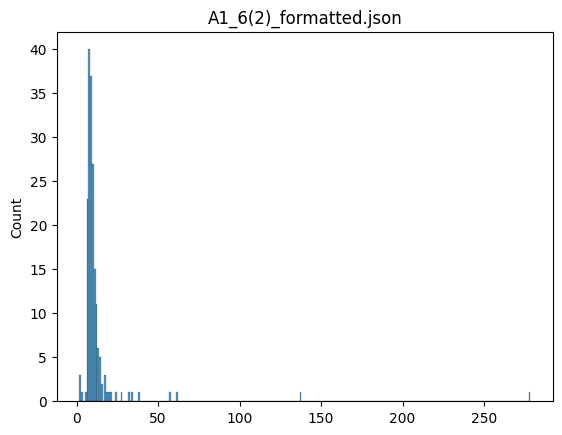

Working on А2_3_formatted.json...


100%|██████████| 472/472 [00:51<00:00,  9.15it/s]


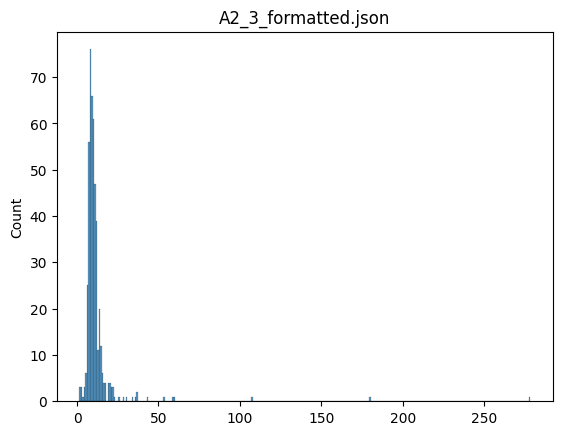

Working on А2_5_formatted.json...


100%|██████████| 211/211 [00:37<00:00,  5.61it/s]


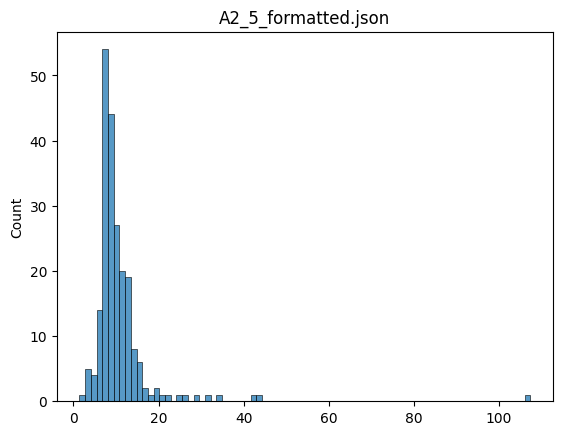

Working on A1_5_formatted.json...


100%|██████████| 325/325 [00:47<00:00,  6.91it/s]


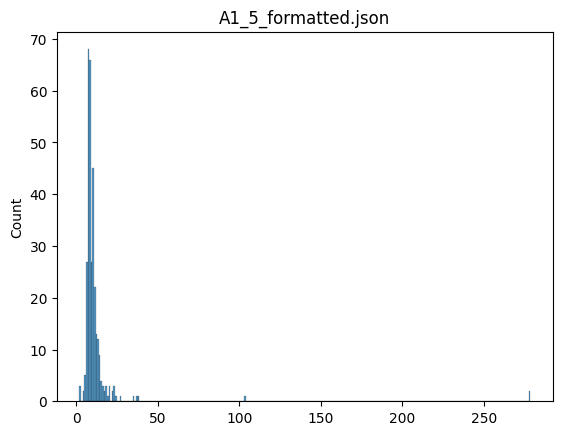

Working on А2_4_formatted.json...


100%|██████████| 108/108 [00:10<00:00, 10.01it/s]


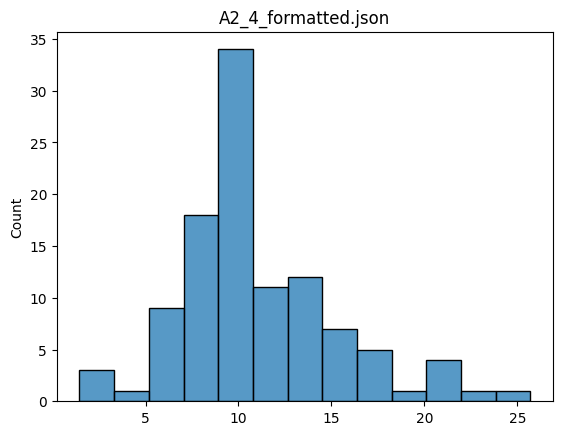

Working on A1_6(1)_formatted.json...


100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


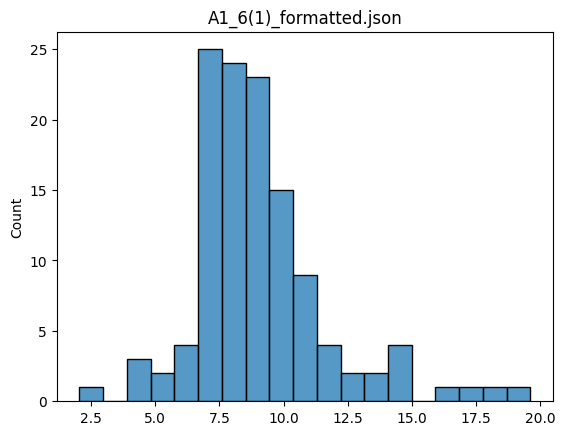

Working on А1_7_formatted.json...


100%|██████████| 393/393 [00:53<00:00,  7.29it/s]


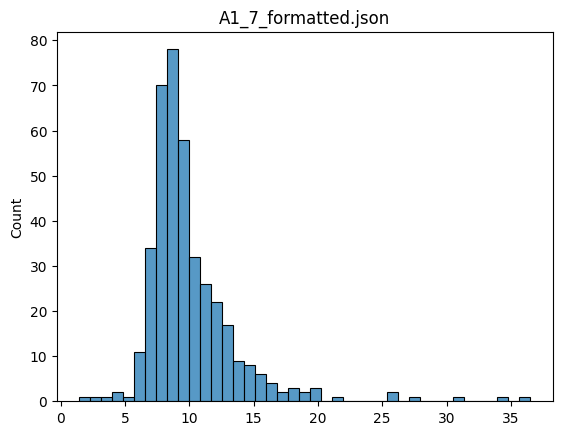

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def split_text_on_sentence_boundary(text):
    sentence_endings = list(re.finditer(r"[.!?]+(?=\s|$)", text))
    if not sentence_endings:
        mid = len(text) // 2
        return text[:mid], text[mid:]
    
    mid = len(text) // 2
    closest = min(sentence_endings, key=lambda m: abs(m.start() - mid))

    split_idx = closest.end()
    return text[:split_idx].strip(), text[split_idx:].strip()

delta_seconds = 0
for filename in os.listdir(transcription_folder):
    if filename.lower().endswith("_formatted.json"):
        with open(transcription_folder+filename, "r", encoding="utf-8") as json_file:
            cur_transcript = json.load(json_file)
        print(f"Working on {filename}...")
        file_perplexities = []
        for segment in tqdm(cur_transcript):
            if len(segment['text'].split(' ')) > 150:
                chunk1, chunk2 = split_text_on_sentence_boundary(segment['text'])
                try:
                    file_perplexities.append(perplexity(chunk1))
                    file_perplexities.append(perplexity(chunk2))
                except:
                    continue
            else:
                file_perplexities.append(perplexity(segment['text']))
        
        plt.figure()  
        plt.title(filename)
        sns.histplot(file_perplexities)
        plt.show()

# whisperx inference

In [24]:
import os 
os.environ["PATH"] += os.pathsep + "/home/llm_agent/ffmpeg"

In [ ]:
import whisperx
import gc

hf_token = ""
device = "cuda"
batch_size = 16
compute_type = "float16" 

model = whisperx.load_model("large-v3", device, compute_type=compute_type, language='ru')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/2.39k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

vocabulary.json:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

>>Performing voice activity detection using Pyannote...
Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.0+cu126. Bad things might happen unless you revert torch to 1.x.


In [ ]:
model_a, metadata = whisperx.load_align_model(language_code='ru', device=device)

In [ ]:
import os
import json
from pydub import AudioSegment
from tqdm import tqdm

audio_folder = "data/seul_game/audio/"
chunk_size = 30

for filename in os.listdir(audio_folder):
    if filename.lower().endswith(".wav"):
        print(f"Working on {filename}...")
        audio_file = os.path.join(audio_folder, filename)
        audio = whisperx.load_audio(audio_file)
        result = model.transcribe(audio, batch_size=batch_size, chunk_size=chunk_size)
        aligned = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

        transcript_path = f"{os.path.splitext(filename)[0]}.json"
        with open(transcript_path, "w", encoding="utf-8") as f:
            json.dump(aligned, f, ensure_ascii=False, indent=4)
        print(f"Transcription saved to {transcript_path}!")

        print("Working on audio chunks...")
        audio = AudioSegment.from_file(audio_file)
        for id, seg in tqdm(enumerate(aligned["segments"])):
            start_ms = int(seg["start"] * 1000)
            end_ms   = int(seg["end"]   * 1000)
            chunk = audio[start_ms:end_ms]
            out_name = f"{audio_folder}chunks/{os.path.splitext(filename)[0]}_{id:04d}.wav"
            chunk.export(out_name, format="wav")

Working on A1.5.wav...
Failed to align segment (" Продолжение следует."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Transcription saved to A1.5.json!
Working on audio chunks...


1145it [00:00, 1179.19it/s]


Working on А2.3.wav...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Transcription saved to А2.3.json!
Working on audio chunks...


1275it [00:00, 1581.92it/s]


Working on А2.5.wav...
Transcription saved to А2.5.json!
Working on audio chunks...


1051it [00:00, 1238.09it/s]


Working on А1.7.wav...
Failed to align segment (" Продолжение следует."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Transcription saved to А1.7.json!
Working on audio chunks...


1369it [00:00, 3647.52it/s]


Working on A1.6.wav...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Transcription saved to A1.6.json!
Working on audio chunks...


1335it [00:00, 3323.15it/s]


Working on А2.4(2).wav...
Transcription saved to А2.4(2).json!
Working on audio chunks...


479it [00:00, 1400.88it/s]


Working on А2.4.wav...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Failed to align segment (" Продолжение следует..."): backtrack failed, resorting to original...
Transcription saved to А2.4.json!
Working on audio chunks...


301it [00:00, 1421.02it/s]
